In [1]:
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import ElasticNet, LassoCV ,Lasso, Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import scipy.stats as stats
from lightgbm import LGBMRegressor
from sklearn import preprocessing
import matplotlib
import seaborn as sns
from sklearn import utils 
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



ModuleNotFoundError: No module named 'xgboost'

In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 219.2/255.9 MB 874.2 kB/s eta 0:00:42
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 437, in _error_catcher
    yield
  File "/usr/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "/usr/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/usr/lib/python3.10/site-packages/pip/_vendor/cachecontrol/filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.10/http/client.py", line 465, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", l

In [4]:
#jсчитываем данные
train_df = pd.read_csv('../datasets/train_house_price.csv')
test_df = pd.read_csv('../datasets/test_house_price.csv')


In [6]:
test_ides = test_df['Id'].copy()

In [7]:
y_train = train_df['SalePrice'].copy()
all_data = pd.concat([train_df, test_df])


all_data.drop(['Id','SalePrice'],axis=1,inplace=True)

<AxesSubplot:>

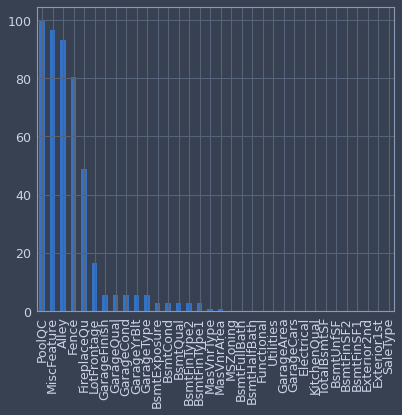

In [8]:
#посмотрим как распределяются пропущенные значения 

miss_all_data = all_data.isna().sum()[all_data.isna().sum() != 0].sort_values(ascending = False)/len(all_data)*100
miss_all_data.plot.bar()

In [9]:
miss_all_data

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Functional       0.068517
Utilities        0.068517
GarageArea       0.034258
GarageCars       0.034258
Electrical       0.034258
KitchenQual      0.034258
TotalBsmtSF      0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64

In [10]:
all_data.drop(['PoolQC', 'MiscFeature', 'Alley','Fence','FireplaceQu'], axis=1, inplace=True)

In [11]:
#MSSubClass, OverallQual, OverallCond это категориальнst переменные по условию 
#превратим их в строчный формат для исключения бессмысленных арифметических операций 

pd.unique(all_data['MSSubClass']), pd.unique(all_data['OverallQual']), pd.unique(all_data['OverallCond'])

(array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
        180,  40, 150]),
 array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2]),
 array([5, 8, 6, 7, 4, 2, 3, 9, 1]))

In [12]:

def make_str_ctg(df,list_features):
    df = df.copy()
    for feature in list_features:
        for num in pd.unique(df[feature]):
            df.loc[df[feature] == num, feature] = f'{feature}_{num}'
    return df

all_data = make_str_ctg(all_data,['MSSubClass','OverallQual', 'OverallCond'])


In [13]:
pd.unique(all_data['MSSubClass']), '\n',pd.unique(all_data['OverallQual']), '\n',pd.unique(all_data['OverallCond'])

(array(['MSSubClass_60', 'MSSubClass_20', 'MSSubClass_70', 'MSSubClass_50',
        'MSSubClass_190', 'MSSubClass_45', 'MSSubClass_90',
        'MSSubClass_120', 'MSSubClass_30', 'MSSubClass_85',
        'MSSubClass_80', 'MSSubClass_160', 'MSSubClass_75',
        'MSSubClass_180', 'MSSubClass_40', 'MSSubClass_150'], dtype=object),
 '\n',
 array(['OverallQual_7', 'OverallQual_6', 'OverallQual_8', 'OverallQual_5',
        'OverallQual_9', 'OverallQual_4', 'OverallQual_10',
        'OverallQual_3', 'OverallQual_1', 'OverallQual_2'], dtype=object),
 '\n',
 array(['OverallCond_5', 'OverallCond_8', 'OverallCond_6', 'OverallCond_7',
        'OverallCond_4', 'OverallCond_2', 'OverallCond_3', 'OverallCond_9',
        'OverallCond_1'], dtype=object))

In [14]:
pd.unique(all_data.dtypes)

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [15]:

numeric_features = [i for i in all_data.columns if all_data[i].dtype != 'O']
categorical_features = [i for i in all_data.columns if all_data[i].dtype == 'O']

print(f'{len(numeric_features)} numeric features \n{len(categorical_features)} categorical features')

33 numeric features 
41 categorical features


In [16]:
#заполним оставшиеся пропуски 

def impute_miss(df):
    df = df.copy()
    
    for num_col in numeric_features:
        df[num_col] = df[num_col].fillna(df[num_col].median())
    
    for cat_col in categorical_features:
        df[cat_col] = df[cat_col].fillna('None')
    
    return df

all_data = impute_miss(all_data)

all_data.isna().sum().sum()

0

#### проверим распределения признаков на нормальность

In [17]:

is_normal_features = {}

for col in numeric_features:
    is_normal_features[col] = not stats.shapiro(all_data.loc[:,'LotArea'])[1] < 0.01

In [18]:
# список признаков которые нормально распределены 
[feature for feature in is_normal_features.keys() if is_normal_features[feature] == True]

[]

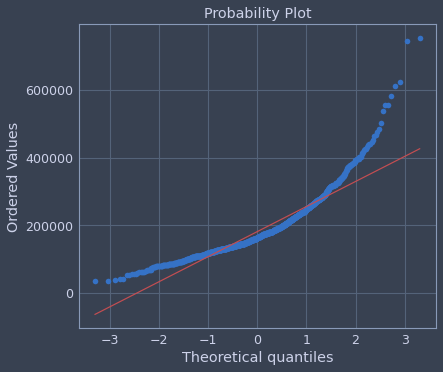

In [19]:
#распределение целевой переменной
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

####    вывод: ни один из признаков не распределен нормально, целевая переменная также имеет явно выраженную ассиметрию 
                               

#### посмотрим на корреляцию признаков

[Text(0.5, 1.0, 'Корреляция > 0.7')]

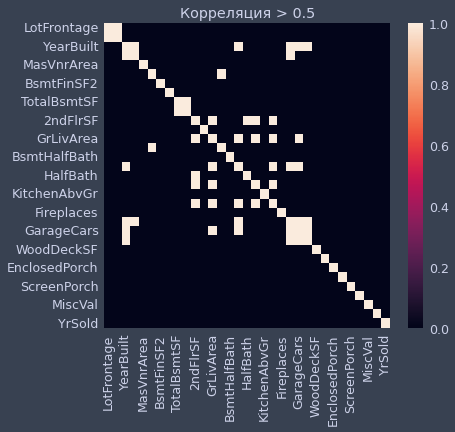

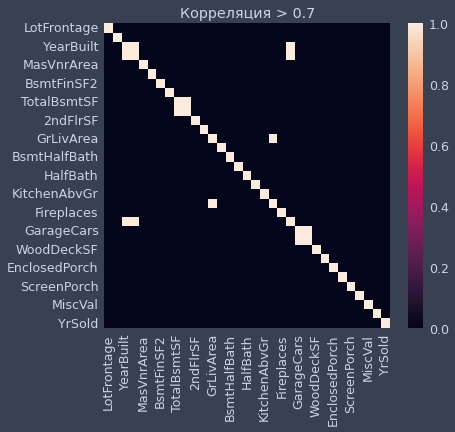

In [20]:
#построим тепловую карту сразу с порогом
# будем использовать корреляцию спирмана потому что она может найти нелинейные зависимости 

plt.figure('dasda')
sns.heatmap(all_data.corr('spearman') >= 0.5).set(title='Корреляция > 0.5')
plt.figure()
sns.heatmap(all_data.corr('spearman') >= 0.7).set(title='Корреляция > 0.7')

In [21]:

def correl(X_train, thresh):
    cor = X_train.corr('spearman')
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    all_cor = c1[c1.values != 1]
    return all_cor[abs(all_cor) > thresh]

correl(all_data,0.5)

GarageCars    GarageArea      0.864719
GarageYrBlt   YearBuilt       0.857059
1stFlrSF      TotalBsmtSF     0.828735
TotRmsAbvGrd  GrLivArea       0.808775
YearRemodAdd  GarageYrBlt     0.714244
YearBuilt     YearRemodAdd    0.707957
BsmtFullBath  BsmtFinSF1      0.667052
TotRmsAbvGrd  BedroomAbvGr    0.663443
GrLivArea     FullBath        0.662752
2ndFlrSF      HalfBath        0.619286
GrLivArea     2ndFlrSF        0.604574
YearBuilt     GarageCars      0.600616
GarageCars    GarageYrBlt     0.577040
LotArea       LotFrontage     0.570995
TotRmsAbvGrd  2ndFlrSF        0.554216
GarageYrBlt   GarageArea      0.551438
FullBath      GarageYrBlt     0.538547
              YearBuilt       0.537464
              TotRmsAbvGrd    0.536076
YearBuilt     GarageArea      0.534138
FullBath      GarageCars      0.527948
GrLivArea     BedroomAbvGr    0.525690
              GarageCars      0.525428
BedroomAbvGr  2ndFlrSF        0.500984
BsmtUnfSF     BsmtFinSF1     -0.547410
dtype: float64

#### вывод: в данных присутвует мультиколлинеарность признаков 

### Итог: 
#### -признаки распределены не нормально
#### -целевая переменная распределена не нормально нужно ее логарифмировать
#### -в данных есть мультиколлинеарность 

## 2.Предобработка данных 

#### добавляем новые признаки

In [22]:

#общая площадь
all_data['All_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])
# площадь дома общая 
all_data['All_SF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# общее количчество ванных комнат 
all_data['All_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# общая площадь веранд 
all_data['All_porch'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

all_data['has_bsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

all_data['has_pool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

all_data['has_fire_place'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

all_data['has_2_floor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

all_data['has_garage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

all_data['Year_Blt+Remod'] = all_data['YearRemodAdd'] + all_data['YearBuilt']

#### теперь кодируем категориальные переменные с помошью One-Hot encoding

In [23]:
all_data = pd.get_dummies(all_data)


#### нормализуем данные

In [24]:
#scalar = preprocessing.StandardScaler()

#all_data[numeric_features] = scalar.fit_transform(all_data[numeric_features])

In [25]:
all_data.shape, train_df.shape,test_df.shape

((2919, 329), (1460, 81), (1459, 80))

In [26]:
train_df = all_data[:train_df.shape[0]]
test_df = all_data[:test_df.shape[0]]

y_train = np.log1p(y_train)

train_df.shape, test_df.shape

((1460, 329), (1459, 329))

## 3.Подбор гиперпараметров и обучение моделей

In [27]:
X = train_df.values
y = y_train.values
train_df

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,All_sqr_footage,All_SF,All_Bathrooms,All_porch,has_bsmt,has_pool,has_fire_place,has_2_floor,has_garage,Year_Blt+Remod,MSSubClass_MSSubClass_120,MSSubClass_MSSubClass_150,MSSubClass_MSSubClass_160,MSSubClass_MSSubClass_180,MSSubClass_MSSubClass_190,MSSubClass_MSSubClass_20,MSSubClass_MSSubClass_30,MSSubClass_MSSubClass_40,MSSubClass_MSSubClass_45,MSSubClass_MSSubClass_50,MSSubClass_MSSubClass_60,MSSubClass_MSSubClass_70,MSSubClass_MSSubClass_75,MSSubClass_MSSubClass_80,MSSubClass_MSSubClass_85,MSSubClass_MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_None,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_OverallQual_1,OverallQual_OverallQual_10,OverallQual_OverallQual_2,OverallQual_OverallQual_3,OverallQual_OverallQual_4,OverallQual_OverallQual_5,OverallQual_OverallQual_6,OverallQual_OverallQual_7,OverallQual_OverallQual_8,OverallQual_OverallQual_9,OverallCond_OverallCond_1,OverallCond_OverallCond_2,OverallCond_OverallCond_3,OverallCond_OverallCond_4,OverallCond_OverallCond_5,OverallCond_OverallCond_6,OverallCond_OverallCond_7,OverallCond_OverallCond_8,OverallCond_OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA

In [28]:
y_train

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [29]:
alphas_r = np.arange(14,16,0.1)
alphas_l = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

kfolds = KFold(random_state=36,shuffle=True)

ridge = RidgeCV(alphas=alphas_r, cv=7)
lasso = LassoCV(alphas=alphas_l, cv=7)


In [44]:
round(mean_squared_log_error(y,lasso.predict(X)),4)

0.0001

In [47]:
outputs = pd.DataFrame({'Id':test_ides,'SalePrice':np.exp(lasso.predict(test_df.values))})
outputs
outputs.to_csv('sub_house_prices_mean_models1.csv', index=False)

In [33]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
grdboost = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', 
                                random_state =42)                             

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )


In [34]:
xgboost.fit(X,y)
grdboost.fit(X,y)
lightgbm.fit(X,y)

[19:09:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, learning_rate=0.01,
              max_bin=200, n_estimators=5000, num_leaves=4,
              objective='regression', verbose=-1)

In [37]:
np.exp(lightgbm.predict(test_df)).round(2)

array([205639.1 , 174119.9 , 215004.21, ..., 204079.54, 265547.48,
       146167.51])

In [32]:
def mean_predicts(X):
    
    return np.exp(((ridge.predict(X)) + lasso.predict(X) + xgboost.predict(X) + grdboost.predict(X) + lightgbm.predict(X))/5)

In [143]:
outputs.to_csv('sub_house_prices_mean_models.csv', index=False)


In [77]:
outputs

,Id,SalePrice
0,1461,204886.155947
1,1462,182822.726786
2,1463,213645.456879
3,1464,176419.517448
4,1465,296422.188811
...,...,...
1454,2915,194428.563408
1455,2916,179141.161992
1456,2917,203907.509271
1457,2918,255554.559209
